In [1]:
from pathlib import Path
import numpy as np
import pickle

rng = np.random.default_rng(42)
DATA_PATH = Path('dataset.pkl')

if DATA_PATH.exists():
    with DATA_PATH.open('rb') as f:
        data, xi_enc, xi_dec, xo_dec = pickle.load(f)
else:
    n = 5000
    s1 = 0.5 * np.sin(np.pi * 0.06 * np.arange(n)) + 0.1 * rng.standard_normal(n)
    s2 = 0.5 * np.sin(np.pi * 0.05 * np.arange(n)) + 0.1 * rng.standard_normal(n)
    data = np.vstack([s1, s2]).T.astype(np.float32)

    seq_len = 50
    m = n - 2 * seq_len + 1
    xi_enc = np.array([data[i:i + seq_len] for i in range(m)], dtype=np.float32)
    xi_dec = np.array([data[i + seq_len - 1:i + 2 * seq_len - 1] for i in range(m)], dtype=np.float32)
    xo_dec = np.array([data[i + seq_len:i + 2 * seq_len] for i in range(m)], dtype=np.float32)

    with DATA_PATH.open('wb') as f:
        pickle.dump((data, xi_enc, xi_dec, xo_dec), f)

# Garantir le bon type même après chargement
data = data.astype(np.float32)
xi_enc = xi_enc.astype(np.float32)
xi_dec = xi_dec.astype(np.float32)
xo_dec = xo_dec.astype(np.float32)

print(f'data shape      : {data.shape}')
print(f'encoder input   : {xi_enc.shape}')
print(f'decoder input   : {xi_dec.shape}')
print(f'decoder targets : {xo_dec.shape}')


data shape      : (5000, 2)
encoder input   : (4901, 50, 2)
decoder input   : (4901, 50, 2)
decoder targets : (4901, 50, 2)


In [2]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    # Encodeur GRU : retourne uniquement l'état caché final.
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

    def forward(self, x_enc):
        _, hidden = self.gru(x_enc)
        return hidden


In [3]:
import torch.nn as nn

class Decoder(nn.Module):
    # Décodeur GRU produisant un pas de sortie à la fois.
    def __init__(self, output_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(output_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_dec_step, hidden):
        output, hidden = self.gru(x_dec_step, hidden)
        prediction = self.fc_out(output)
        return prediction, hidden


In [4]:
import random
import torch
import torch.nn as nn

class Seq2Seq(nn.Module):
    # Modèle encodeur-décodeur Seq2Seq avec teacher forcing optionnel.
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, x_enc, x_dec, teacher_forcing_ratio: float = 0.5):
        batch_size, target_len, output_dim = x_dec.size()
        outputs = torch.zeros(batch_size, target_len, output_dim, device=self.device)
        hidden = self.encoder(x_enc)
        decoder_input = x_dec[:, 0, :].unsqueeze(1)

        for t in range(target_len):
            output_step, hidden = self.decoder(decoder_input, hidden)
            outputs[:, t, :] = output_step.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            if t + 1 < target_len and teacher_force:
                decoder_input = x_dec[:, t + 1, :].unsqueeze(1)
            else:
                decoder_input = output_step
        return outputs


## Entraînement du Seq2Seq

Nous divisons les 4 901 séquences en un ensemble d'entraînement (85 %) et de validation (15 %).
Le teacher forcing décroît linéairement pour favoriser un déroulé libre stable.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from pathlib import Path

SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

INPUT_DIM = xi_enc.shape[-1]
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 60
LEARNING_RATE = 1e-3
TF_START = 0.7
TF_END = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_enc_tensor = torch.from_numpy(xi_enc).float()
x_dec_tensor = torch.from_numpy(xi_dec).float()
y_tensor = torch.from_numpy(xo_dec).float()

dataset = TensorDataset(x_enc_tensor, x_dec_tensor, y_tensor)
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

encoder = Encoder(INPUT_DIM, HIDDEN_DIM).to(device)
decoder = Decoder(INPUT_DIM, HIDDEN_DIM).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def run_epoch(loader, teacher_forcing_ratio, train=True):
    epoch_loss = 0.0
    if train:
        model.train()
    else:
        model.eval()
    for x_enc_batch, x_dec_batch, y_batch in loader:
        x_enc_batch = x_enc_batch.to(device)
        x_dec_batch = x_dec_batch.to(device)
        y_batch = y_batch.to(device)

        if train:
            optimizer.zero_grad()
            outputs = model(x_enc_batch, x_dec_batch, teacher_forcing_ratio)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        else:
            with torch.no_grad():
                outputs = model(x_enc_batch, x_dec_batch, teacher_forcing_ratio=0.0)
                loss = criterion(outputs, y_batch)

        epoch_loss += loss.item() * x_enc_batch.size(0)
    return epoch_loss / len(loader.dataset)

history = {'train_loss': [], 'val_loss': []}

for epoch in range(1, EPOCHS + 1):
    tf_ratio = max(TF_END, TF_START - (TF_START - TF_END) * (epoch - 1) / max(EPOCHS - 1, 1))
    train_loss = run_epoch(train_loader, tf_ratio, train=True)
    val_loss = run_epoch(val_loader, 0.0, train=False)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch:02d}/{EPOCHS} | tf_ratio={tf_ratio:.2f} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}')

MODEL_PATH = Path('seq2seq_model.pth')
torch.save(model.state_dict(), MODEL_PATH)
print(f'Model saved to {MODEL_PATH.resolve()}')


Epoch 01/60 | tf_ratio=0.70 | train_loss=0.058938 | val_loss=0.038013
Epoch 05/60 | tf_ratio=0.66 | train_loss=0.011263 | val_loss=0.012713
Epoch 10/60 | tf_ratio=0.61 | train_loss=0.011007 | val_loss=0.010832
Epoch 15/60 | tf_ratio=0.56 | train_loss=0.010594 | val_loss=0.010803
Epoch 20/60 | tf_ratio=0.51 | train_loss=0.010499 | val_loss=0.010794
Epoch 25/60 | tf_ratio=0.46 | train_loss=0.010574 | val_loss=0.011982
Epoch 30/60 | tf_ratio=0.41 | train_loss=0.010515 | val_loss=0.010801
Epoch 35/60 | tf_ratio=0.35 | train_loss=0.010627 | val_loss=0.010824
Epoch 40/60 | tf_ratio=0.30 | train_loss=0.010468 | val_loss=0.010643
Epoch 45/60 | tf_ratio=0.25 | train_loss=0.010599 | val_loss=0.011475
Epoch 50/60 | tf_ratio=0.20 | train_loss=0.011212 | val_loss=0.010899
Epoch 55/60 | tf_ratio=0.15 | train_loss=0.010500 | val_loss=0.010480
Epoch 60/60 | tf_ratio=0.10 | train_loss=0.010770 | val_loss=0.010720
Model saved to /home/dev_ap/Documents/2025_COURS_ENSTA_DEEPLEARNING/public_repos/Session3/

### Courbes de perte

Les pertes sont exprimées en MSE sur les signaux normalisés. Comparez train/validation pour surveiller le sur-apprentissage.


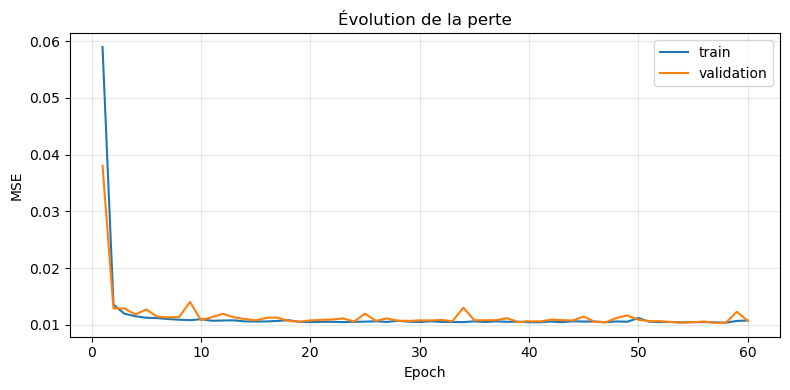

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(8, 4))
plt.plot(epochs, history['train_loss'], label='train')
plt.plot(epochs, history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Évolution de la perte')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Évaluation et génération

Comparaison teacher forcing / déroulé libre sur une séquence tenue à part, puis projection libre sur un horizon étendu pour analyser la dérive.


MSE (teacher forcing) : 0.007671
MSE (déroulé libre)   : 0.007428


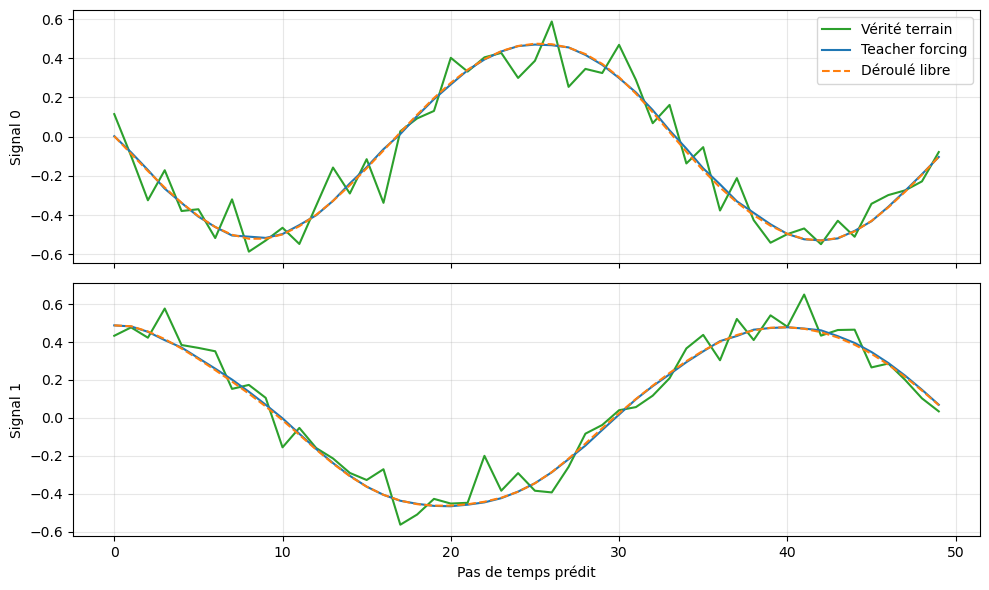

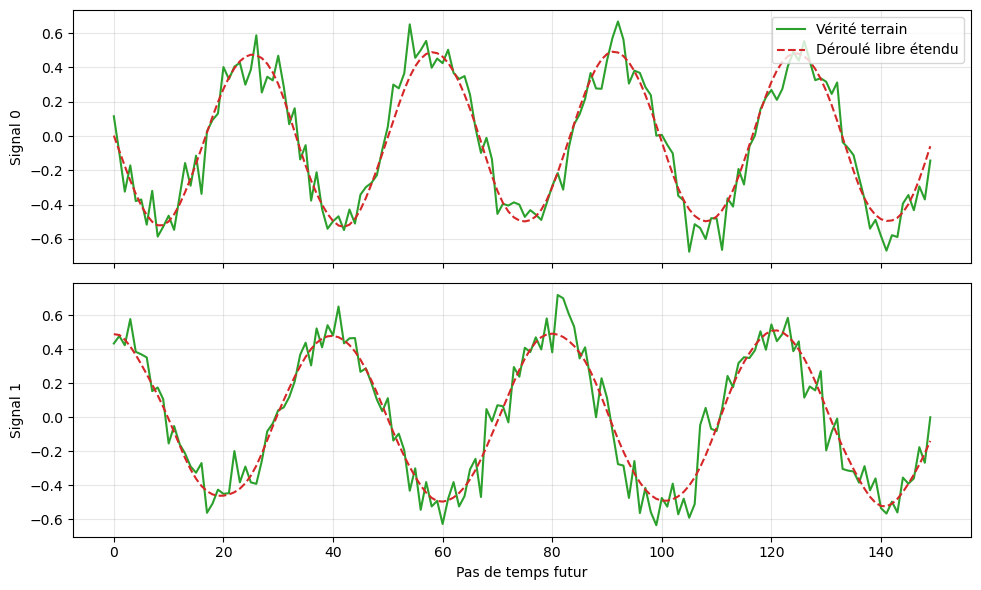

In [7]:
import torch
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('dataset.pkl', 'rb') as f:
    data, xi_enc_np, xi_dec_np, xo_dec_np = pickle.load(f)

data = data.astype(np.float32)
xi_enc_np = xi_enc_np.astype(np.float32)
xi_dec_np = xi_dec_np.astype(np.float32)
xo_dec_np = xo_dec_np.astype(np.float32)

input_dim = xi_enc_np.shape[-1]
hidden_dim = globals().get('HIDDEN_DIM', 128)

encoder = Encoder(input_dim, hidden_dim).to(device)
decoder = Decoder(input_dim, hidden_dim).to(device)
seq2seq = Seq2Seq(encoder, decoder, device).to(device)

state_path = Path('seq2seq_model.pth')
seq2seq.load_state_dict(torch.load(state_path, map_location=device))
seq2seq.eval()

sample_idx = 3200
seed_enc = torch.from_numpy(xi_enc_np[sample_idx:sample_idx + 1]).to(device)
seed_dec = torch.from_numpy(xi_dec_np[sample_idx:sample_idx + 1]).to(device)
target = xo_dec_np[sample_idx]

with torch.no_grad():
    preds_teacher = seq2seq(seed_enc, seed_dec, teacher_forcing_ratio=1.0).cpu().numpy().squeeze(0)
    preds_free = seq2seq(seed_enc, seed_dec, teacher_forcing_ratio=0.0).cpu().numpy().squeeze(0)

mse_teacher = np.mean((preds_teacher - target) ** 2)
mse_free = np.mean((preds_free - target) ** 2)
print(f'MSE (teacher forcing) : {mse_teacher:.6f}')
print(f'MSE (déroulé libre)   : {mse_free:.6f}')

steps = np.arange(target.shape[0])
fig, axes = plt.subplots(input_dim, 1, figsize=(10, 6), sharex=True)
if input_dim == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    ax.plot(steps, target[:, i], label='Vérité terrain', color='tab:green')
    ax.plot(steps, preds_teacher[:, i], label='Teacher forcing', color='tab:blue')
    ax.plot(steps, preds_free[:, i], label='Déroulé libre', color='tab:orange', linestyle='--')
    ax.set_ylabel(f'Signal {i}')
    ax.grid(alpha=0.3)
axes[-1].set_xlabel('Pas de temps prédit')
axes[0].legend(loc='upper right')
plt.tight_layout()
plt.show()

def rollout(seq2seq_model, seed_sequence, horizon):
    preds = []
    hidden = seq2seq_model.encoder(seed_sequence)
    decoder_input = seed_sequence[:, -1:, :]
    with torch.no_grad():
        for _ in range(horizon):
            output_step, hidden = seq2seq_model.decoder(decoder_input, hidden)
            preds.append(output_step.cpu())
            decoder_input = output_step
    return torch.cat(preds, dim=1).numpy().squeeze(0)

seed_length = seed_enc.size(1)
max_future = data.shape[0] - (sample_idx + seed_length)
future_horizon = min(150, max_future)
if future_horizon > 0:
    extended_pred = rollout(seq2seq, seed_enc, future_horizon)
    future_truth = data[sample_idx + seed_length: sample_idx + seed_length + future_horizon]
    future_steps = np.arange(future_horizon)
    fig, axes = plt.subplots(input_dim, 1, figsize=(10, 6), sharex=True)
    if input_dim == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.plot(future_steps, future_truth[:, i], label='Vérité terrain', color='tab:green')
        ax.plot(future_steps, extended_pred[:, i], label='Déroulé libre étendu', color='tab:red', linestyle='--')
        ax.set_ylabel(f'Signal {i}')
        ax.grid(alpha=0.3)
    axes[-1].set_xlabel('Pas de temps futur')
    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print("Horizon supplémentaire nul : l\'indice choisi est trop proche de la fin du signal.")


### Visualisation interactive des entrées / sorties

Le widget ci-dessous permet de sélectionner l'indice de départ dans le jeu de données et de comparer les prédictions du modèle Seq2Seq entraîné en *teacher forcing* et en déroulé libre. Utilisez le curseur pour analyser différentes zones du signal synthétique.

In [8]:
try:
    import ipywidgets as widgets
    from IPython.display import display
except ImportError:
    widgets = None
    from IPython.display import Markdown
    display(Markdown('> **Note :** installez `ipywidgets` (`pip install ipywidgets`) pour activer le widget interactif.'))

if 'seq2seq' not in globals():
    raise RuntimeError('Chargez le modèle seq2seq (cellule précédente) avant d\'utiliser le widget.')

SEED_RANGE = (0, xi_enc_np.shape[0] - 1)
DEFAULT_IDX = min(3500, SEED_RANGE[1])


def plot_prediction(index=DEFAULT_IDX):
    index = int(index)
    seed_enc = torch.from_numpy(xi_enc_np[index:index+1]).to(device)
    seed_dec = torch.from_numpy(xi_dec_np[index:index+1]).to(device)
    target = xo_dec_np[index]
    
    # --- AJOUT ---
    # On récupère la longueur de la séquence d'amorçage (seed) du décodeur.
    # C'est le nombre de pas de temps que le modèle "connaît" avant de devoir prédire.
    # La forme de seed_dec est (batch_size, sequence_length, num_features), donc on prend la 2ème dimension.
    start_pred_step = seed_dec.shape[1]
    
    with torch.no_grad():
        preds_teacher = seq2seq(seed_enc, seed_dec, teacher_forcing_ratio=1.0).cpu().numpy().squeeze(0)
        preds_free = seq2seq(seed_enc, seed_dec, teacher_forcing_ratio=0.0).cpu().numpy().squeeze(0)
    
    steps = np.arange(target.shape[0])
    fig, axes = plt.subplots(target.shape[1], 1, figsize=(9, 5), sharex=True)
    if target.shape[1] == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.plot(steps, target[:, i], label='Vérité', color='tab:green')
        ax.plot(steps, preds_teacher[:, i], label='Teacher forcing', color='tab:blue', alpha=0.85)
        ax.plot(steps, preds_free[:, i], label='Déroulé libre', color='tab:orange', linestyle='--')
        
        # --- AJOUT ---
        # On trace une ligne verticale à la position (longueur de la seed - 1).
        # Le "- 1" est dû au fait que les indices commencent à 0. C'est le dernier point CONNU.
        # La prédiction libre commence juste après cette ligne.
        # On ajoute le label uniquement sur le premier graphique pour éviter les doublons dans la légende.
        label = 'Début de la prédiction' if i == 0 else None
        ax.axvline(x=start_pred_step - 1, color='tab:red', linestyle=':', linewidth=2, label=label)
        
        ax.set_ylabel(f'Signal {i}')
        ax.grid(alpha=0.3)
    axes[-1].set_xlabel('Pas de temps prédit')
    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

if widgets is not None:
    index_slider = widgets.IntSlider(value=DEFAULT_IDX, min=SEED_RANGE[0], max=SEED_RANGE[1], step=1,
                                     description='Index', continuous_update=False)
    display(widgets.interactive_output(plot_prediction, {'index': index_slider}))
    display(index_slider)
else:
    plot_prediction(index=DEFAULT_IDX)


Output()

IntSlider(value=3500, continuous_update=False, description='Index', max=4900)

---

## Extension : intégrer un mécanisme d'attention

Nous enrichissons maintenant l'architecture avec une attention additive (Bahdanau). Le décodeur pondère dynamiquement les sorties de l'encodeur pour chaque pas de temps, améliorant la cohérence de la synthèse.

In [9]:
class EncoderWithContext(nn.Module):
    # Encodeur GRU renvoyant la séquence complète et l'état caché final.
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

    def forward(self, x_enc):
        outputs, hidden = self.gru(x_enc)
        return outputs, hidden


class AdditiveAttention(nn.Module):
    # Attention additive (Bahdanau).
    def __init__(self, hidden_dim):
        super().__init__()
        self.alignment = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden_expanded = hidden[-1].unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.alignment(torch.cat((hidden_expanded, encoder_outputs), dim=2)))
        attn_scores = self.v(energy).squeeze(2)
        attn_weights = torch.softmax(attn_scores, dim=1)
        return attn_weights


class AttentionDecoder(nn.Module):
    # Décodeur GRU conditionné par le contexte d'attention.
    def __init__(self, output_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.attention = AdditiveAttention(hidden_dim)
        self.gru = nn.GRU(output_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_dec_step, hidden, encoder_outputs):
        attn_weights = self.attention(hidden, encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        gru_input = torch.cat((x_dec_step, context), dim=2)
        output, hidden = self.gru(gru_input, hidden)
        prediction = self.fc_out(output)
        return prediction, hidden, attn_weights


class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, x_enc, x_dec, teacher_forcing_ratio=0.5, return_attn=False):
        encoder_outputs, hidden = self.encoder(x_enc)
        batch_size, target_len, output_dim = x_dec.size()
        outputs = torch.zeros(batch_size, target_len, output_dim, device=self.device)
        attn_list = []
        decoder_input = x_dec[:, 0, :].unsqueeze(1)

        for t in range(target_len):
            output_step, hidden, attn_weights = self.decoder(decoder_input, hidden, encoder_outputs)
            outputs[:, t, :] = output_step.squeeze(1)
            if return_attn:
                attn_list.append(attn_weights.unsqueeze(1))
            teacher_force = random.random() < teacher_forcing_ratio
            if t + 1 < target_len and teacher_force:
                decoder_input = x_dec[:, t + 1, :].unsqueeze(1)
            else:
                decoder_input = output_step

        if return_attn:
            attn_tensor = torch.cat(attn_list, dim=1)
            return outputs, attn_tensor
        return outputs


### Entraînement du modèle avec attention

Nous réutilisons le même jeu de données et la même politique de décroissance du teacher forcing pour entraîner le modèle attentif.

In [10]:
ATTN_HIDDEN_DIM = 128
ATTN_EPOCHS = 60
ATTN_LR = 1e-3
ATTN_TF_START = 0.7
ATTN_TF_END = 0.1

attn_encoder = EncoderWithContext(INPUT_DIM, ATTN_HIDDEN_DIM).to(device)
attn_decoder = AttentionDecoder(INPUT_DIM, ATTN_HIDDEN_DIM).to(device)
attn_model = Seq2SeqAttention(attn_encoder, attn_decoder, device).to(device)

attn_optimizer = optim.Adam(attn_model.parameters(), lr=ATTN_LR)
attn_history = {'train_loss': [], 'val_loss': []}


def run_epoch_attention(loader, teacher_forcing_ratio, train=True):
    epoch_loss = 0.0
    if train:
        attn_model.train()
    else:
        attn_model.eval()
    for x_enc_batch, x_dec_batch, y_batch in loader:
        x_enc_batch = x_enc_batch.to(device)
        x_dec_batch = x_dec_batch.to(device)
        y_batch = y_batch.to(device)

        if train:
            attn_optimizer.zero_grad()
            outputs = attn_model(x_enc_batch, x_dec_batch, teacher_forcing_ratio)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(attn_model.parameters(), max_norm=1.0)
            attn_optimizer.step()
        else:
            with torch.no_grad():
                outputs = attn_model(x_enc_batch, x_dec_batch, teacher_forcing_ratio=0.0)
                loss = criterion(outputs, y_batch)

        epoch_loss += loss.item() * x_enc_batch.size(0)
    return epoch_loss / len(loader.dataset)

for epoch in range(1, ATTN_EPOCHS + 1):
    tf_ratio = max(ATTN_TF_END, ATTN_TF_START - (ATTN_TF_START - ATTN_TF_END) * (epoch - 1) / max(ATTN_EPOCHS - 1, 1))
    train_loss = run_epoch_attention(train_loader, tf_ratio, train=True)
    val_loss = run_epoch_attention(val_loader, 0.0, train=False)
    attn_history['train_loss'].append(train_loss)
    attn_history['val_loss'].append(val_loss)
    if epoch % 5 == 0 or epoch == 1:
        print(f'[ATTN] Epoch {epoch:02d}/{ATTN_EPOCHS} | tf_ratio={tf_ratio:.2f} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}')

ATTN_MODEL_PATH = Path('seq2seq_attention_model.pth')
torch.save(attn_model.state_dict(), ATTN_MODEL_PATH)
print(f'Model with attention saved to {ATTN_MODEL_PATH.resolve()}')


[ATTN] Epoch 01/60 | tf_ratio=0.70 | train_loss=0.056341 | val_loss=0.072922
[ATTN] Epoch 05/60 | tf_ratio=0.66 | train_loss=0.011276 | val_loss=0.012934
[ATTN] Epoch 10/60 | tf_ratio=0.61 | train_loss=0.010750 | val_loss=0.011843
[ATTN] Epoch 15/60 | tf_ratio=0.56 | train_loss=0.010675 | val_loss=0.010672
[ATTN] Epoch 20/60 | tf_ratio=0.51 | train_loss=0.010540 | val_loss=0.011301
[ATTN] Epoch 25/60 | tf_ratio=0.46 | train_loss=0.010526 | val_loss=0.011040
[ATTN] Epoch 30/60 | tf_ratio=0.41 | train_loss=0.010457 | val_loss=0.010587
[ATTN] Epoch 35/60 | tf_ratio=0.35 | train_loss=0.010477 | val_loss=0.010870
[ATTN] Epoch 40/60 | tf_ratio=0.30 | train_loss=0.010568 | val_loss=0.011426
[ATTN] Epoch 45/60 | tf_ratio=0.25 | train_loss=0.010352 | val_loss=0.010630
[ATTN] Epoch 50/60 | tf_ratio=0.20 | train_loss=0.010359 | val_loss=0.011106
[ATTN] Epoch 55/60 | tf_ratio=0.15 | train_loss=0.010403 | val_loss=0.010665
[ATTN] Epoch 60/60 | tf_ratio=0.10 | train_loss=0.010323 | val_loss=0.010689

### Pertes comparées (avec attention)

Superposez les courbes de validation pour analyser l'apport de l'attention.

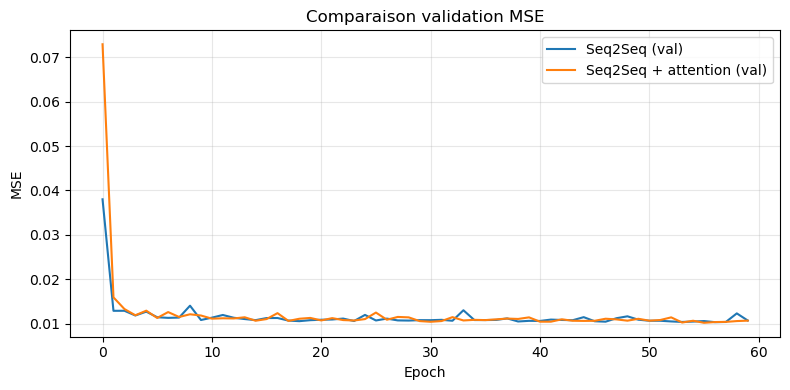

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(history['val_loss'], label='Seq2Seq (val)', color='tab:blue')
plt.plot(attn_history['val_loss'], label='Seq2Seq + attention (val)', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Comparaison validation MSE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Visualisation des poids d'attention

Pour un exemple donné, on trace les pondérations d'attention (pas décodeur vs pas encodeur) obtenues en déroulé libre.

Attention weights shape: (50, 50)


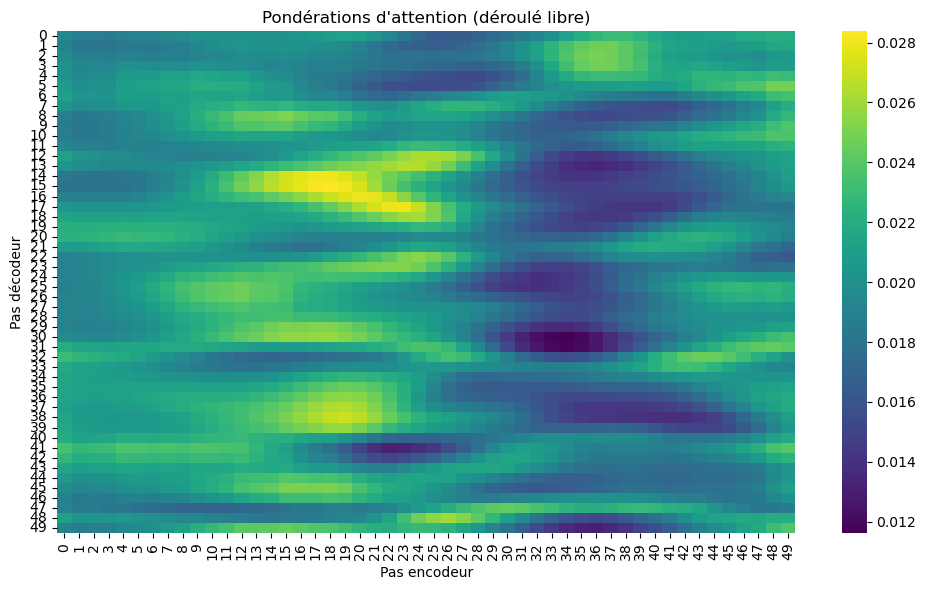

In [12]:
import seaborn as sns
attn_model.eval()
attn_model.load_state_dict(torch.load(ATTN_MODEL_PATH, map_location=device))

ATTN_SAMPLE_IDX = 3200
seed_enc_attn = torch.from_numpy(xi_enc_np[ATTN_SAMPLE_IDX:ATTN_SAMPLE_IDX + 1]).to(device)
seed_dec_attn = torch.from_numpy(xi_dec_np[ATTN_SAMPLE_IDX:ATTN_SAMPLE_IDX + 1]).to(device)

with torch.no_grad():
    preds_attn, attn_weights = attn_model(seed_enc_attn, seed_dec_attn, teacher_forcing_ratio=0.0, return_attn=True)

attn_weights_np = attn_weights.squeeze(0).cpu().numpy()
print('Attention weights shape:', attn_weights_np.shape)

tgt_steps = np.arange(attn_weights_np.shape[0])
src_steps = np.arange(attn_weights_np.shape[1])

plt.figure(figsize=(10, 6))
sns.heatmap(attn_weights_np, cmap='viridis', xticklabels=src_steps, yticklabels=tgt_steps)
plt.xlabel('Pas encodeur')
plt.ylabel('Pas décodeur')
plt.title('Pondérations d\'attention (déroulé libre)')
plt.tight_layout()
plt.show()
